In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import numpy as np
import jax.numpy as jnp

from compressible_core import chemistry_utils, energy_models
from compressible_2d import (
    mesh_gmsh,
    equation_manager,
    equation_manager_types,
    equation_manager_utils,
    numerics_types,
)

### setup

In [30]:
# Load mesh and solution
repo_root = Path("/home/hhoechter/tum/jaxfluids_internship")
data_dir = repo_root / "data"

mesh = mesh_gmsh.read_gmsh_v2_wedge_plane(
    str(data_dir / "bluntedCone.msh"),
    wedge_plane_tag=4,
    remap_tags={7: 7},
    axis_tag=7,
)
sol = np.load(str(repo_root / "experiments/blunt_cone_2d/solution_subsonic.npz"))
U_hist = sol["U"]
t_hist = sol["t"]
print(f"U shape: {U_hist.shape}, t: {t_hist}")
print(f"Mesh cells: {mesh.cell_areas.shape[0]}")

# Build a minimal equation manager for extract_primitives
species_names = ("N2",)
energy_cfg = energy_models.EnergyModelConfig(
    model="bird",
    include_electronic=False,
    data_path=str(data_dir / "air_5_bird_energy.json"),
)
species = chemistry_utils.load_species_table(
    species_names=species_names,
    general_data_path=str(data_dir / "species.json"),
    energy_model_config=energy_cfg,
)

boundary_tags = np.unique(mesh.boundary_tags)
tag_to_bc = {int(tag): {"type": "outflow"} for tag in boundary_tags if tag >= 0}

boundary_config = equation_manager_types.BoundaryConditionConfig2D(tag_to_bc=tag_to_bc)

numerics_config = numerics_types.NumericsConfig2D(
    dt=1e-9,
    cfl=0.4,
    dt_mode="fixed",
    integrator_scheme="rk2",
    spatial_scheme="first_order",
    flux_scheme="hllc",
    axisymmetric=True,
    clipping=numerics_types.ClippingConfig2D(),
)

eq_manager = equation_manager.build_equation_manager(
    mesh,
    species=species,
    collision_integrals=None,
    reactions=None,
    numerics_config=numerics_config,
    boundary_config=boundary_config,
    transport_model=None,
    casseau_transport=None,
)

U shape: (11, 120000, 5), t: [0.0000000e+00 4.9999645e-08 1.0000019e-07 1.5000109e-07 2.0000198e-07
 2.5000122e-07 2.9999501e-07 3.4998880e-07 3.9998258e-07 4.4997637e-07
 4.9997016e-07]
Mesh cells: 120000


In [31]:
jnp.all(jnp.isnan(U_hist[1:, :, :]))

Array(False, dtype=bool)

In [32]:
import jax.numpy as jnp

# Build triangulation (shared across all time steps)
triangles_i, triangles_j, triangles_k = [], [], []
for cell_nodes in mesh.cells:
    n = len(cell_nodes)
    if n == 3:
        triangles_i += [cell_nodes[0]]
        triangles_j += [cell_nodes[1]]
        triangles_k += [cell_nodes[2]]
    elif n == 4:
        triangles_i += [cell_nodes[0], cell_nodes[0]]
        triangles_j += [cell_nodes[1], cell_nodes[2]]
        triangles_k += [cell_nodes[2], cell_nodes[3]]

triangles = np.column_stack(
    [np.array(triangles_i), np.array(triangles_j), np.array(triangles_k)]
)
nodes_x = np.array(mesh.nodes[:, 0])
nodes_y = np.array(mesh.nodes[:, 1])
print(f"n_cells={len(mesh.cells)}, n_triangles={len(triangles)}")


def cell_to_tri_vals(cell_values):
    """Map cell-centered values to per-triangle values (quads produce 2 triangles)."""
    tri_vals = []
    for cell_idx, cell_nodes in enumerate(mesh.cells):
        tri_vals.append(cell_values[cell_idx])
        if len(cell_nodes) == 4:
            tri_vals.append(cell_values[cell_idx])
    return np.array(tri_vals)


# Extract primitives for all time steps
n_steps = U_hist.shape[0]
all_primitives = []
for i in range(n_steps):
    Y_s, rho, u, v, T, Tv, p = equation_manager_utils.extract_primitives_from_U(
        jnp.array(U_hist[i]), eq_manager
    )
    all_primitives.append(
        {
            "rho [kg/m3]": np.array(rho),
            "u [m/s]": np.array(u),
            "v [m/s]": np.array(v),
            "T [K]": np.array(T),
            "Tv [K]": np.array(Tv),
            "p [Pa]": np.array(p),
        }
    )

print(f"Extracted primitives for {n_steps} time steps.")

n_cells=120000, n_triangles=240000
Extracted primitives for 11 time steps.


### plot t x primitives

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.tri as mtri

triang = mtri.Triangulation(nodes_x, nodes_y, triangles)
primitive_names = list(all_primitives[0].keys())
n_prims = len(primitive_names)
n_cols = len(all_primitives)

fig, axes = plt.subplots(n_prims, n_cols, figsize=(3.5 * n_cols, 3.0 * n_prims))

for row, name in enumerate(primitive_names):
    all_vals = np.concatenate(
        [cell_to_tri_vals(all_primitives[col][name]) for col in range(n_cols)]
    )
    finite = all_vals[np.isfinite(all_vals)]
    vmin = np.percentile(finite, 1) if len(finite) else 0.0
    vmax = np.percentile(finite, 99) if len(finite) else 1.0

    for col in range(n_cols):
        ax = axes[row, col]
        tri_vals = cell_to_tri_vals(all_primitives[col][name])
        tc = ax.tripcolor(
            triang,
            facecolors=tri_vals,
            cmap="plasma",
            shading="flat",
            vmin=vmin,
            vmax=vmax,
        )
        if row == 0:
            ax.set_title(f"t = {float(t_hist[col]):.2e} s", fontsize=9)
        if col == 0:
            ax.set_ylabel(name, fontsize=9)
        ax.set_aspect("equal")
        ax.tick_params(labelsize=7)
        if col == n_cols - 1:
            fig.colorbar(tc, ax=ax, fraction=0.046, pad=0.04)

plt.suptitle(
    "Primitive variables — rows: variable, columns: time step", fontsize=11, y=1.01
)
plt.tight_layout()
out = repo_root / "experiments/blunt_cone_2d/primitives_all_steps.png"
plt.savefig(out, dpi=120, bbox_inches="tight")
print(f"Saved to {out}")
plt.show()

### plot t= primitives

n_cells=120000, n_nodes=241401, n_triangles=240000
t_last = 5.000e-10 s


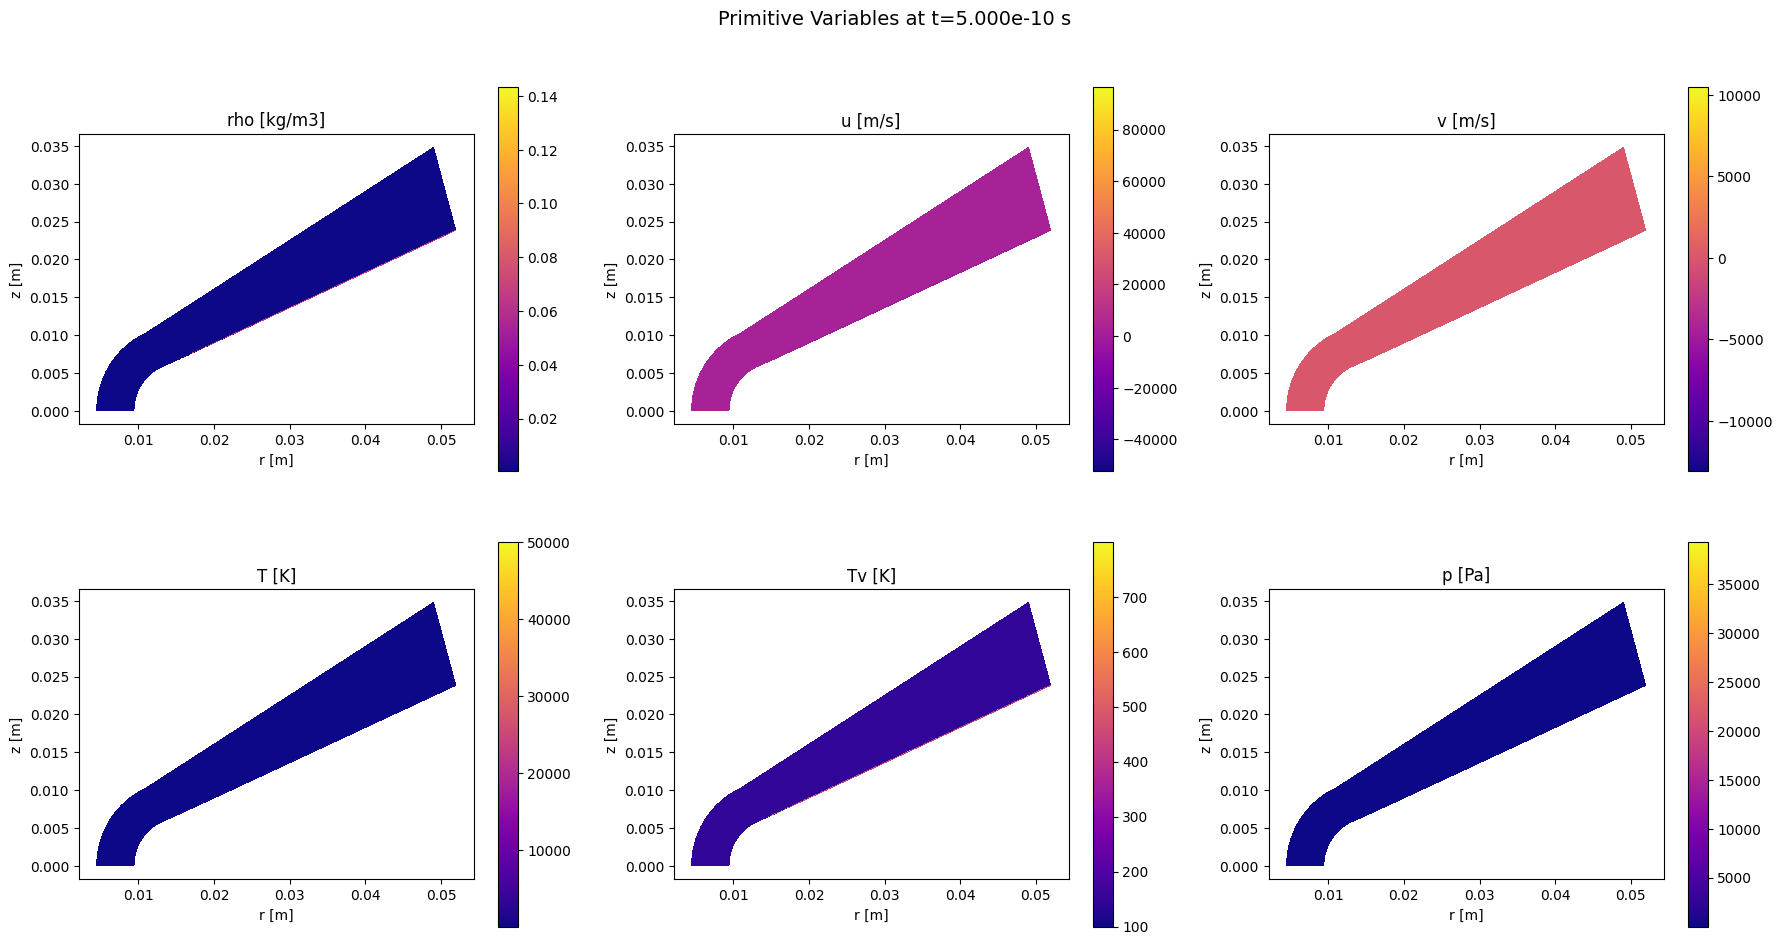

In [47]:
# plot one time step

import matplotlib.pyplot as plt
import matplotlib.tri as mtri

# Extract primitives at last timestep
U_last = U_hist[-1]
Y_s, rho, u, v, T, Tv, p = equation_manager_utils.extract_primitives_from_U(
    U_last, eq_manager
)

# Cell centroids for scatter positions
cx = np.array(mesh.cell_centroids[:, 0])  # r (radial)
cy = np.array(mesh.cell_centroids[:, 1])  # z (axial)

# Build triangulation from mesh cells for filled contour-like plots
triangles_i, triangles_j, triangles_k = [], [], []
for cell_nodes in mesh.cells:
    n = len(cell_nodes)
    if n == 3:
        triangles_i.append(cell_nodes[0])
        triangles_j.append(cell_nodes[1])
        triangles_k.append(cell_nodes[2])
    elif n == 4:
        # Split quad into two triangles
        triangles_i.append(cell_nodes[0])
        triangles_j.append(cell_nodes[1])
        triangles_k.append(cell_nodes[2])
        triangles_i.append(cell_nodes[0])
        triangles_j.append(cell_nodes[2])
        triangles_k.append(cell_nodes[3])

triangles_i = np.array(triangles_i)
triangles_j = np.array(triangles_j)
triangles_k = np.array(triangles_k)

nodes_x = np.array(mesh.nodes[:, 0])
nodes_y = np.array(mesh.nodes[:, 1])

print(
    f"n_cells={len(mesh.cells)}, n_nodes={mesh.nodes.shape[0]}, n_triangles={len(triangles_i)}"
)
print(f"t_last = {float(t_hist[-1]):.3e} s")

# Build a Triangulation object for matplotlib
# Each cell is a triangle (or quad split into 2 triangles)
triangles = np.column_stack([triangles_i, triangles_j, triangles_k])
triang = mtri.Triangulation(nodes_x, nodes_y, triangles)

primitives = {
    "rho [kg/m3]": np.array(rho),
    "u [m/s]": np.array(u),
    "v [m/s]": np.array(v),
    "T [K]": np.array(T),
    "Tv [K]": np.array(Tv),
    "p [Pa]": np.array(p),
}


# Map cell values to triangle values (for quads, both sub-triangles get the same value)
def cell_to_triangle_values(cell_values):
    """Map cell-centered values to per-triangle values (quads produce 2 triangles)."""
    tri_vals = []
    for cell_idx, cell_nodes in enumerate(mesh.cells):
        n = len(cell_nodes)
        tri_vals.append(cell_values[cell_idx])
        if n == 4:
            tri_vals.append(cell_values[cell_idx])
    return np.array(tri_vals)


fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, (name, values) in enumerate(primitives.items()):
    ax = axes[idx]
    tri_vals = cell_to_triangle_values(values)
    tc = ax.tripcolor(triang, facecolors=tri_vals, cmap="plasma", shading="flat")
    fig.colorbar(tc, ax=ax, shrink=0.8)
    ax.set_title(name)
    ax.set_xlabel("r [m]")
    ax.set_ylabel("z [m]")
    ax.set_aspect("equal")

fig.suptitle(f"Primitive Variables at t={float(t_hist[-1]):.3e} s", fontsize=14)
plt.tight_layout()
plt.show()

### velocity quiver

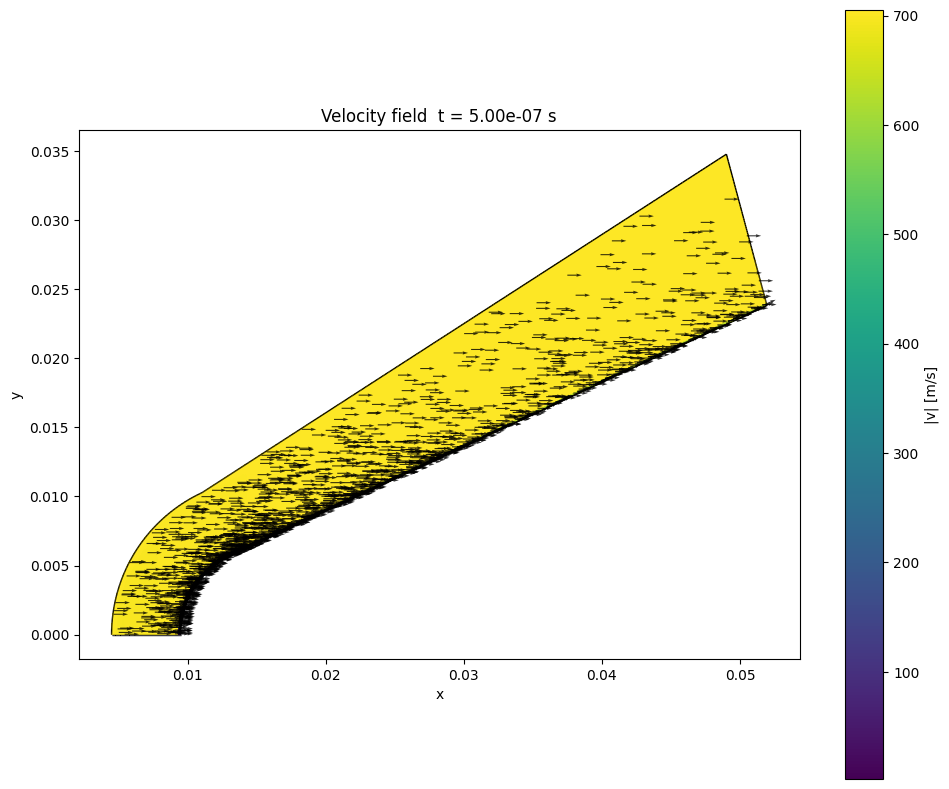

In [33]:
import matplotlib.pyplot as plt
import matplotlib.collections as mc
import matplotlib.tri as mtri

step = -1  # change to inspect other time steps

u_vals = all_primitives[step]["u [m/s]"]
v_vals = all_primitives[step]["v [m/s]"]
speed = np.sqrt(u_vals**2 + v_vals**2)

cx = mesh.cell_centroids[:, 0]
cy = mesh.cell_centroids[:, 1]

rng = np.random.default_rng(0)
idx = rng.choice(len(cx), size=2000, replace=False)

s = speed[idx] + 1e-30
u_norm = u_vals[idx] / s
v_norm = v_vals[idx] / s

fig, ax = plt.subplots(figsize=(10, 8))

tc = ax.tripcolor(
    triang, facecolors=cell_to_tri_vals(speed), cmap="viridis", shading="flat"
)
fig.colorbar(tc, ax=ax, label="|v| [m/s]")

ax.quiver(
    cx[idx],
    cy[idx],
    u_norm,
    v_norm,
    color="black",
    angles="xy",
    scale=50,
    width=1.5e-3,
    headwidth=3,
    alpha=0.8,
)

boundary_segs = [
    [mesh.nodes[mesh.face_nodes[fi, 0]], mesh.nodes[mesh.face_nodes[fi, 1]]]
    for fi in np.where(mesh.face_right == -1)[0]
]
ax.add_collection(mc.LineCollection(boundary_segs, colors="black", linewidths=1.0))

ax.set_aspect("equal")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title(f"Velocity field  t = {float(t_hist[step]):.2e} s")
plt.tight_layout()
plt.show()

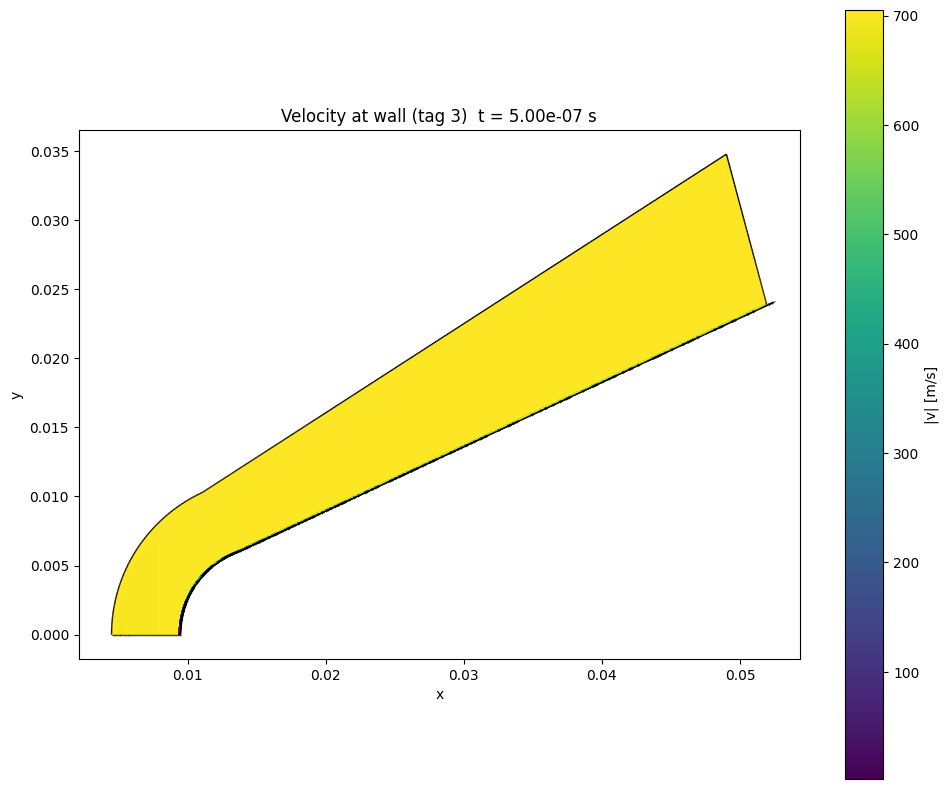

In [34]:
import matplotlib.pyplot as plt
import matplotlib.collections as mc

step = -1  # change to inspect other time steps

u_vals = all_primitives[step]["u [m/s]"]
v_vals = all_primitives[step]["v [m/s]"]
speed = np.sqrt(u_vals**2 + v_vals**2)

# Tag-3 faces: position at face centroid, velocity from adjacent cell (face_left)
tag3_fi = np.where((mesh.face_right == -1) & (mesh.boundary_tags == 3))[0]
# Subsample tag-3 faces
rng = np.random.default_rng(0)
tag3_fi = rng.choice(tag3_fi, size=min(200, len(tag3_fi)), replace=False)
tag3_cx = mesh.face_centroids[tag3_fi, 0]
tag3_cy = mesh.face_centroids[tag3_fi, 1]
tag3_cells = mesh.face_left[tag3_fi]
tag3_u = u_vals[tag3_cells]
tag3_v = v_vals[tag3_cells]
tag3_spd = speed[tag3_cells]

s = tag3_spd + 1e-30
u_norm = tag3_u / s
v_norm = tag3_v / s

fig, ax = plt.subplots(figsize=(10, 8))

tc = ax.tripcolor(
    triang, facecolors=cell_to_tri_vals(speed), cmap="viridis", shading="flat"
)
fig.colorbar(tc, ax=ax, label="|v| [m/s]")

ax.quiver(
    tag3_cx,
    tag3_cy,
    u_norm,
    v_norm,
    color="black",
    angles="xy",
    scale=50,
    width=1.5e-3,
    headwidth=3,
    alpha=0.9,
)

boundary_segs = [
    [mesh.nodes[mesh.face_nodes[fi, 0]], mesh.nodes[mesh.face_nodes[fi, 1]]]
    for fi in np.where(mesh.face_right == -1)[0]
]
ax.add_collection(mc.LineCollection(boundary_segs, colors="black", linewidths=1.0))

ax.set_aspect("equal")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title(f"Velocity at wall (tag 3)  t = {float(t_hist[step]):.2e} s")
plt.tight_layout()
plt.show()